# VAE for Text-to-Image Retrival

This notebook implements a deep learning model that translates text embeddings into image embeddings for cross-modal retrieval tasks. The model learns to map textual descriptions to their corresponding visual representations using a supervised contrastive learning approach.

## Overview
- **Task**: Text-to-Image Retrieval
- **Architecture**: Variation autoencoder with Layer Normalization
- **Framework**: PyTorch Lightning
- **Optimization**: Contrastive Learning with Temperature Scaling

## Configuration Setup

Import required libraries and verify hardware availability.

In [1]:
# !pip install torch torchvision pytorch-lightning numpy pandas matplotlib pillow scikit-learn tqdm rich

print("✅ All dependencies installed successfully!")

✅ All dependencies installed successfully!


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path

print(f"✅ Imports complete")
print(f"   PyTorch version: {torch.__version__}")
print(f"   Lightning version: {pl.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")

✅ Imports complete
   PyTorch version: 2.9.0+cu128
   Lightning version: 2.5.6
   CUDA available: True


## Download and Unzip the Dataset

Dataset downloads require authentication. Ensure your kaggle.json credentials file is located in the same directory as this notebook file before running the download script.

In [3]:
import os
import zipfile
import shutil

target_folder = "./data"
zip_filename = "aml-competition.zip"
zip_path = os.path.join(target_folder, zip_filename)

train_folder = os.path.join(target_folder, "train")
test_folder = os.path.join(target_folder, "test")

os.makedirs(target_folder, exist_ok=True)

if os.path.exists(train_folder) and os.path.exists(test_folder):
    print(f"✅ Folders 'train' and 'test' already exist in '{target_folder}'. Skipping everything.")

else:
    if not os.path.exists(zip_path):
        print(f"⬇️ Downloading {zip_filename}...")
        
        os.environ['KAGGLE_CONFIG_DIR'] = '.'
        !chmod 600 ./kaggle.json
        !kaggle competitions download -c aml-competition -p {target_folder}
        
        if os.path.exists(zip_path):
            print("Download complete.")
        else:
            raise FileNotFoundError("❌ Download failed!")
    else:
        print(f"📦 Zip file found at '{zip_path}'.")

    print(f"📂 Extracting {zip_filename}...")
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(target_folder)
        
        for folder_name in ['train', 'test']:
            outer_folder = os.path.join(target_folder, folder_name)
            inner_folder = os.path.join(outer_folder, folder_name)
            
            if os.path.exists(inner_folder):
                print(f"📁 Fixing nested structure for '{folder_name}'...")
                
                for item in os.listdir(inner_folder):
                    src = os.path.join(inner_folder, item)
                    dst = os.path.join(outer_folder, item)
                    shutil.move(src, dst)
                
                os.rmdir(inner_folder)
        
        print(f"✅ Extraction complete! Data is properly structured in '{target_folder}'")
        
    except zipfile.BadZipFile:
        print("❌ Error: The zip file is corrupted. Please delete it and try downloading again.")

✅ Folders 'train' and 'test' already exist in './data'. Skipping everything.


### Hyperparameters and Configuration

Define all model hyperparameters, training configuration, and paths. These values were optimized through hyperparameter tuning.### 1.2 Configurations

In [4]:
# Model checkpoint and directory paths
MODEL_PATH = "models/vae/model.pth"
CHECKPOINT_DIR = "checkpoints"

# The path to the data directory, which should contain 'train' and 'test' subfolders.
# The 'train' and 'test' folders should each contain the respective .npz files.
DATA_DIR = r"data/"

# Training hyperparameters
EPOCHS = 100
LATENT_DIM = 896
BATCH_SIZE = 512
LR = 4e-4
WEIGHT_DECAY = 5e-3
TRAIN_VALIDATION_SPLIT = 0.9
BETA = 0.2
BETA_WARM_UP = 5
DROPOUT1 = 0.7
DROPOUT2 = 0.7
HIDDEN_DIM1 = 2048
HIDDEN_DIM2 = 3072
FINAL_DIM = 1536

# Reproducibility
SEED = 42
pl.seed_everything(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training flag
TRAIN_MODEL = True

print(f"🔧 Configuration:")
print(f"   Device: {DEVICE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LR}")
print(f"   Epochs: {EPOCHS}")

Seed set to 42


🔧 Configuration:
   Device: cuda
   Batch size: 512
   Learning rate: 0.0004
   Epochs: 100


# Data Loading and Preprocessing

Load pre-computed embeddings from the training dataset and prepare them for model training.## 2. Data Preparation

## Helper Functions

Utility functions for loading and preparing the dataset.

In [5]:
def load_data(path):
    """
    Load processed data from .npz file containing pre-computed embeddings.

    Args:
        path (str): Path to the .npz file

    Returns:
        dict: Dictionary containing embeddings and metadata
    """
    data = dict(np.load(path, allow_pickle=True))
    return data


def prepare_train_data(data):
    """
    Prepare training data from loaded dictionary by aligning caption and image embeddings.

    Each caption is paired with its corresponding image embedding based on the label matrix.
    The label matrix is a sparse matrix where label[i, j] = 1 indicates that caption i
    corresponds to image j.

    IMPORTANT: This function now tracks image indices to handle multiple labels per image
    in the contrastive loss computation.

    Args:
        data (dict): Dictionary containing embeddings and label matrix

    Returns:
        tuple: (X, y, image_indices) where:
            - X: Caption embeddings (N, text_dim)
            - y: Corresponding image embeddings (N, image_dim)
            - image_indices: Image index for each caption (N,) - used for multi-label loss
    """
    caption_embd = data["captions/embeddings"]
    image_embd = data["images/embeddings"]
    label = data["captions/label"]  # Shape: (N_captions, M_images)

    # Map each caption to its corresponding image using the label matrix
    label_idx = np.nonzero(label)[1]  # Extract column indices of non-zero entries
    print(f"Label indices shape: {label_idx.shape}")

    # Check for multiple labels per image
    unique_images = len(np.unique(label_idx))
    print(f"Unique images: {unique_images} (from {len(label_idx)} caption-image pairs)")
    print(f"Average captions per image: {len(label_idx) / unique_images:.2f}")

    # Align image embeddings with captions
    image_embd = image_embd[label_idx]

    assert (
        caption_embd.shape[0] == image_embd.shape[0]
    ), "Mismatch in number of caption and image embeddings"

    # Convert to PyTorch tensors
    X = torch.from_numpy(caption_embd).float()
    y = torch.from_numpy(image_embd).float()
    image_indices = torch.from_numpy(label_idx).long()  # Track which image each caption corresponds to

    print(f"Prepared data: {len(X)} caption-image pairs")
    return X, y, image_indices

## Loading Training Data

Load the pre-computed embeddings from the training set.

In [6]:
print("📦 Loading training data...")
train_data = load_data(DATA_DIR + "/train/train.npz")
X, y, image_indices = prepare_train_data(train_data)
DATASET_SIZE = len(X)
print(f"✅ Loaded {DATASET_SIZE} training samples")
print(f"   Text embeddings shape: {X.shape}")
print(f"   Image embeddings shape: {y.shape}")
print(f"   Image indices shape: {image_indices.shape}")

📦 Loading training data...
Label indices shape: (125000,)
Unique images: 25000 (from 125000 caption-image pairs)
Average captions per image: 5.00
Prepared data: 125000 caption-image pairs
✅ Loaded 125000 training samples
   Text embeddings shape: torch.Size([125000, 1024])
   Image embeddings shape: torch.Size([125000, 1536])
   Image indices shape: torch.Size([125000])


## Train/Validation Split

Split the dataset into training and validation sets (90/10 split).

In [7]:
# Create 90/10 train/validation split
n_train = int(TRAIN_VALIDATION_SPLIT * len(X))
print(f"Dataset split: {n_train}/{len(X)} samples for training/validation")

TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]
image_indices_train, image_indices_val = image_indices[TRAIN_SPLIT], image_indices[~TRAIN_SPLIT]

# Create PyTorch datasets with image indices for multi-label loss
train_dataset = TensorDataset(X_train, y_train, image_indices_train)
val_dataset = TensorDataset(X_val, y_val, image_indices_val)

# Create data loaders with optimized batch size
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)

print(f"✅ DataLoaders created")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

Dataset split: 112500/125000 samples for training/validation
✅ DataLoaders created
   Training batches: 220
   Validation batches: 25


# Model Architecture

Define the neural network architecture and training procedure using PyTorch Lightning.

## Translator Network

The core VAE architecture that maps text embeddings to image embeddings with L2 normalization.

In [8]:
class ResidualCylinderBlock(nn.Module):
    """
    Implements a single residual block with a "cylinder" feed-forward network.

    This block applies a two-layer Multi-Layer Perceptron (MLP) and adds its
    output to the original input (residual connection).
    The architecture follows: x -> (self.net(x) + x)

    This structure ensures that the input and output dimensions of the block
    are identical, allowing for stacking and residual connections.

    Args:
        input_dim (int): Dimension of the input and output features.
        hidden_dim (int): Dimension of the internal hidden layer.
        dropout (float, optional): Dropout probability. Defaults to 0.1.

    """
    def __init__(self, input_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x) + x

class CrossModalVAE(nn.Module):
    """
    Asymmetric Variational Autoencoder (VAE) for translating text embeddings
    into a latent distribution, which is then decoded into image embeddings.

    This model is "asymmetric" because the encoder and decoder operate at
    different feature dimensions (e.g., 1024D for text, 1536D for image).

    Architecture:
        - Encoder:
            - Input: Text embeddings (1024D)
            - 1x ResidualCylinderBlock (1024D -> hidden_dim1 -> 1024D)
            - Bottleneck: Two linear layers (1024D -> latent_dim)
              to produce 'mu' and 'logvar'.

        - Latent Space:
            - Samples 'z' from N(mu, logvar) during training
              (deterministic=False).
            - Uses 'z = mu' during evaluation (deterministic=True).

        - Decoder:
            - Input Projection: (latent_dim -> final_dim) + LayerNorm + GELU
            - 1x ResidualCylinderBlock (final_dim -> hidden_dim2 -> final_dim)
            - Final Layer: Linear projection (final_dim -> final_dim)
            - Output: L2-normalized image embeddings (final_dim).

    The final output is normalized to unit length, making it suitable for
    cosine similarity-based losses (like contrastive loss).
    """
    def __init__(
        self,
        latent_dim: int = 768,
        hidden_dim1: int = 1280,
        hidden_dim2: int = 1280,
        final_dim: int = 1536,
        dropout1: float = 0.1,
        dropout2: float = 0.1
    ):
        super().__init__()
        self.encoder_block1 = ResidualCylinderBlock(
            1024, hidden_dim1, dropout1
        )
        self.mu = nn.Linear(1024, latent_dim)
        self.logvar = nn.Linear(1024, latent_dim)
        self.decoder_input = nn.Sequential(
            nn.Linear(latent_dim, final_dim),
            nn.LayerNorm(final_dim),
            nn.GELU()
        )
        self.decoder_block1 = ResidualCylinderBlock(
            final_dim, hidden_dim2, dropout2
        )
        self.final_layer = nn.Linear(final_dim, final_dim)

    def encode(self, x):
        h = self.encoder_block1(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def decode(self, z):
        h = self.decoder_input(z)
        h = self.decoder_block1(h)
        recon = self.final_layer(h)
        recon = F.normalize(recon,  p=2, dim=-1)
        return recon

    def forward(self, text_emb: torch.Tensor, deterministic: bool = False):
        mu, logvar = self.encode(text_emb)
        if deterministic:
            z = mu
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std
        image_emb = self.decode(z)
        return image_emb, mu, logvar


    def kl_loss(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


## Lightning Module

PyTorch Lightning module implementing the complete training loop with contrastive learning.

In [9]:
class Translator(pl.LightningModule):
    """
    PyTorch Lightning module for training a CrossModalVAE on a text-to-image task.

    This module acts as the main trainer, wrapping the `CrossModalVAE`.
    It implements the complete VAE loss function:
    `Total Loss = Contrastive Loss + (Beta * KL Loss)`

    Key features:
    - Implements a symmetric, multi-label contrastive loss (similar to CLIP)
      that correctly handles multiple positive text-image pairs per batch.
    - Manages a learnable temperature (logit_scale) for the contrastive loss.
    - Manages a linear warmup schedule for the KL loss weight (beta).
    - Configures AdamW optimizer with a ReduceLROnPlateau scheduler.

    Metrics tracked:
    - Training: Total Loss, Contrastive Loss, KL Loss, Beta,
                  in-batch R@1, Temperature
    - Validation: Total Loss, Contrastive Loss, KL Loss, in-batch R@1,
                  global MRR (epoch-level), global R@(1, 5, 10) (epoch-level)

    Args:
        hidden_dim1 (int): Hidden dim for the VAE Encoder block.
        hidden_dim2 (int): Hidden dim for the VAE Decoder block.
        final_dim (int): Output dimension of the VAE Decoder (image emb).
        latent_dim (int): Dimension of the VAE latent bottleneck.
        dropout1 (float): Dropout rate for the VAE Encoder block.
        dropout2 (float): Dropout rate for the VAE Decoder block.
        learning_rate (float): Initial learning rate for AdamW.
        weight_decay (float): Weight decay (L2 penalty) for AdamW.
        beta (float): The final weight of the KL divergence loss term.
        beta_warmup_epochs (int): Epochs to linearly ramp up beta.
    """
    def __init__(
        self,
        hidden_dim1=1280,
        hidden_dim2=1280,
        final_dim=1536,
        latent_dim=768,
        dropout1=0.1,
        dropout2=0.1,
        learning_rate=1e-4,
        weight_decay=1e-5,
        beta=0.05,
        beta_warmup_epochs=10
    ):
        super().__init__()
        self.save_hyperparameters()

        self.vae = CrossModalVAE(
            latent_dim=latent_dim,
            hidden_dim1= hidden_dim1,
            hidden_dim2= hidden_dim2,
            final_dim=final_dim,
            dropout1=dropout1,
            dropout2=dropout2
        )

        # Learnable temperature parameter for scaling logits
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.6592)

        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Store validation predictions for epoch-end metrics
        self.validation_step_outputs = []

    def forward(self, text_emb, deterministic: bool = False):
        """Forward pass through the vae network."""
        return self.vae(text_emb, deterministic=deterministic)

    def _get_beta(self) -> float:
        """
        Calculates the current BETA value based on a linear warmup schedule.

        Linearly increases BETA from 0.0 to its final `hparams.beta` value
        over the `hparams.beta_warmup_epochs`, then returns the constant
        final BETA value thereafter.
        """
        warmup = max(1, int(self.hparams.beta_warmup_epochs))
        epoch = float(self.current_epoch)
        if epoch >= warmup:
            return float(self.hparams.beta)
        return float(self.hparams.beta) * (epoch / warmup)

    def compute_contrastive_loss(self, pred_image_embs, target_image_embs, image_indices):
        """
        Compute symmetric bidirectional multi-label contrastive loss.

        This loss computes both text→image and image→text directions and averages them.
        Unlike standard InfoNCE which assumes only diagonal elements are positives,
        this loss correctly treats all samples with the same image_index as positives.
        This is crucial when multiple captions correspond to the same image.

        The bidirectional approach provides:
        - Better regularization through dual supervision
        - Symmetric alignment between text and image spaces
        - Similar to CLIP's training objective

        Args:
            pred_image_embs (Tensor): Predicted embeddings (batch_size, dim)
            target_image_embs (Tensor): Ground truth embeddings (batch_size, dim)
            image_indices (Tensor): Image index for each sample (batch_size,)

        Returns:
            tuple: (loss, logits) where:
                - loss: Scalar tensor with the symmetric contrastive loss
                - logits: Similarity matrix (batch_size, batch_size)
        """
        # Normalize embeddings for numerical stability
        target_image_embs = F.normalize(target_image_embs, p=2, dim=-1)

        # Compute cosine similarity matrix: (B, D) @ (D, B) -> (B, B)
        logits = pred_image_embs @ target_image_embs.T

        # Apply temperature scaling
        logits = self.logit_scale.exp() * logits

        # Create multi-label mask: positive_mask[i,j] = 1 if sample i and j share the same image
        positive_mask = (image_indices.unsqueeze(0) == image_indices.unsqueeze(1)).float()

        # Compute loss with multiple positives using logsumexp for numerical stability
        # For each anchor, we want: -log(sum(exp(sim_pos)) / sum(exp(sim_all)))

        # Mask out diagonal for symmetric loss computation
        logits_max = torch.max(logits, dim=1, keepdim=True)[0].detach()
        logits_stable = logits - logits_max

        exp_logits = torch.exp(logits_stable)

        # ============ Text→Image Loss (rows = queries) ============
        # Sum over positives (numerator)
        positive_exp = (exp_logits * positive_mask).sum(dim=1)

        # Sum over all (denominator)
        all_exp = exp_logits.sum(dim=1)

        # Compute log probability: log(sum_pos / sum_all)
        log_prob_t2i = torch.log(positive_exp / all_exp)

        # Average over batch
        loss_t2i = -log_prob_t2i.mean()

        # ============ Image→Text Loss (columns = queries) ============
        # Transpose logits for image→text direction
        logits_i2t = logits.T

        # Recompute stable exponentials for transposed matrix
        logits_max_i2t = torch.max(logits_i2t, dim=1, keepdim=True)[0].detach()
        logits_stable_i2t = logits_i2t - logits_max_i2t
        exp_logits_i2t = torch.exp(logits_stable_i2t)

        # Transpose positive mask as well
        positive_mask_i2t = positive_mask.T

        # Sum over positives and all
        positive_exp_i2t = (exp_logits_i2t * positive_mask_i2t).sum(dim=1)
        all_exp_i2t = exp_logits_i2t.sum(dim=1)

        # Compute log probability
        log_prob_i2t = torch.log(positive_exp_i2t / all_exp_i2t)

        # Average over batch
        loss_i2t = -log_prob_i2t.mean()

        # ============ Symmetric Loss: Average both directions ============
        loss = (loss_t2i + loss_i2t) / 2.0

        return loss, logits


    def training_step(self, batch, batch_idx):
        """
        Performs a single training step.

        Runs the VAE in stochastic mode (deterministic=False), computes the
        combined VAE loss (multi-label contrastive + beta * KL), and logs
        all training metrics including in-batch retrieval@1.
        """
        text_embs, image_embs, image_indices = batch

        pred_image_embs, mu, logvar = self.vae(text_embs, deterministic=False)

        contrastive_loss, logits = self.compute_contrastive_loss(pred_image_embs, image_embs, image_indices)

        kl = self.vae.kl_loss(mu, logvar)

        beta = self._get_beta()

        loss = contrastive_loss + beta * kl

        with torch.no_grad():
            preds = torch.argmax(logits, dim=1)
            correct = (image_indices[preds] == image_indices).float()
            acc = correct.mean()

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_contrastive', contrastive_loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log('train_kl', kl, prog_bar=False, on_step=False, on_epoch=True)
        self.log('train_beta', beta, prog_bar=False, on_step=False, on_epoch=True)
        self.log('train_retrieval@1', acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('temperature', self.logit_scale.exp(), prog_bar=False, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Performs a single validation step.

        Computes and logs the full VAE loss (Contrastive + KL) for the batch
        in deterministic mode, and stores outputs for global epoch-level metrics.
        """
        text_embs, image_embs, image_indices = batch

        pred_image_embs, mu, logvar = self.vae(text_embs, deterministic=True)

        contrastive_loss, logits = self.compute_contrastive_loss(pred_image_embs, image_embs, image_indices)

        kl = self.vae.kl_loss(mu, logvar)
        beta = self._get_beta()
        loss = contrastive_loss + beta * kl

        preds = torch.argmax(logits, dim=1)
        labels = torch.arange(logits.shape[0], device=self.device)
        retrieval_at_1 = (preds == labels).float().mean()

        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_contrastive', contrastive_loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log('val_kl', kl, prog_bar=False, on_step=False, on_epoch=True)
        self.log('val_retrieval@1_batch', retrieval_at_1, prog_bar=True, on_step=False, on_epoch=True)

        self.validation_step_outputs.append({
            'pred_image_embs': pred_image_embs.detach().cpu(),
            'target_image_embs': image_embs.detach().cpu(),
            "image_indices": image_indices.detach().cpu(),
        })

        return loss

    def on_validation_epoch_end(self):
        """
        Compute Mean Reciprocal Rank (MRR) on the entire validation set.

        MRR measures the average reciprocal rank of the correct image in the
        ranked list of retrieved images for each query.

        With multi-label loss, we consider a retrieval correct if it matches
        any sample with the same image index.
        """
        if len(self.validation_step_outputs) == 0:
            return

        all_pred_embs = torch.cat([x['pred_image_embs'] for x in self.validation_step_outputs], dim=0)
        all_target_embs = torch.cat([x['target_image_embs'] for x in self.validation_step_outputs], dim=0)
        all_image_indices = torch.cat([x["image_indices"] for x in self.validation_step_outputs], dim=0)

        all_pred_embs = all_pred_embs.to(self.device)
        all_target_embs = all_target_embs.to(self.device)
        all_image_indices = all_image_indices.to(self.device)

        retrieval_metrics = self.compute_retrieval_at_k(
            all_pred_embs,
            all_target_embs,
            k_values=[1, 5, 10]
        )

        mrr = self.compute_mrr(all_pred_embs, all_target_embs, all_image_indices)

        for metric_name, value in retrieval_metrics.items():
            self.log(f'val_{metric_name}', value, prog_bar=True)
        self.log('val_MRR', mrr, prog_bar=True)

        self.validation_step_outputs.clear()

    def compute_retrieval_at_k(self, pred_embs: torch.Tensor, target_embs: torch.Tensor, k_values=[1, 5, 10]):
        """
        Computes batch-level Retrieval@K metrics (R@1, R@5, R@10).

        This function assumes a (B, B) similarity matrix where the
        positive target for prediction `i` is located only at index `i`
        (i.e., the diagonal).
        """
        target_norm = F.normalize(target_embs, p=2, dim=1)

        similarity = torch.matmul(pred_embs.float(), target_norm.t())

        N = pred_embs.size(0)
        results = {}

        for k in k_values:
            topk = torch.topk(similarity, k=k, dim=1).indices
            labels = torch.arange(N, device=pred_embs.device).unsqueeze(1)
            correct = (topk == labels).any(dim=1).float().sum()
            results[f"retrieval@{k}"] = (correct / N).item()

        return results

    def compute_mrr(self, pred_embs, target_embs, image_indices):
        """
        Compute Mean Reciprocal Rank (MRR) with multi-label awareness.

        For each query, finds the rank of the FIRST retrieved sample that shares
        the same image index. This correctly handles cases where multiple captions
        correspond to the same image.

        Args:
            pred_embs (Tensor): Predicted embeddings (N, dim)
            target_embs (Tensor): Ground truth embeddings (N, dim)
            image_indices (Tensor): Image index for each sample (N,)

        Returns:
            float: Mean Reciprocal Rank
        """
        target_norm = F.normalize(target_embs, p=2, dim=1)

        similarity_matrix = torch.mm(pred_embs, target_norm.t())

        N = len(pred_embs)

        sorted_indices = torch.argsort(similarity_matrix, dim=1, descending=True)

        reciprocal_ranks = []
        for i in range(N):
            query_image_idx = image_indices[i]
            ranked_image_indices = image_indices[sorted_indices[i]]
            matches = torch.where(ranked_image_indices == query_image_idx)[0]
            if len(matches) > 0:
                rank = matches[0].item() + 1
                reciprocal_ranks.append(1.0 / rank)
            else:
                reciprocal_ranks.append(0.0)

        mrr = torch.tensor(reciprocal_ranks).mean().item()
        return mrr


    def configure_optimizers(self):
        """
        Configures the model's optimizer and learning rate scheduler.

        This setup uses the AdamW optimizer. It is paired with a
        ReduceLROnPlateau scheduler, which monitors the 'val_MRR' metric.
        If 'val_MRR' does not improve for a specified number of epochs
        (patience=5), the learning rate will be reduced by a factor of 0.3.
        """
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
            betas=(0.9, 0.999)
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.3,
            patience=5,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_MRR"
            },
        }

## Training Setup

Initialize the model and configure the PyTorch Lightning trainer with callbacks for checkpointing and early stopping.

In [10]:
# Set matrix multiplication precision for performance
torch.set_float32_matmul_precision("medium")

# Initialize model with hyperparameters
model = Translator(final_dim=FINAL_DIM, hidden_dim1=HIDDEN_DIM1, hidden_dim2=HIDDEN_DIM2, latent_dim=LATENT_DIM, dropout1=DROPOUT1, dropout2=DROPOUT2, learning_rate=LR, weight_decay=WEIGHT_DECAY, beta=BETA, beta_warmup_epochs=BETA_WARM_UP)

print(f"✅ Model initialized")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Callback to save best models based on validation MRR
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="vae-{epoch:02d}-{val_MRR:.4f}",
    monitor="val_MRR",
    mode="max",
    save_top_k=5,
    verbose=True,
)

early_stop_callback = EarlyStopping(
    monitor="val_MRR",
    patience=10,
    mode="max",
    verbose=True,
)

# Configure trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        RichProgressBar(refresh_rate=10)
    ],
    log_every_n_steps=10,
    default_root_dir="vae/lightning_logs/",
    precision="16-mixed" if torch.cuda.is_available() else 32,
)

print(f"✅ Trainer configured")
print(f"   Device: {trainer.accelerator}")
print(f"   Precision: {trainer.precision}")
print(f"   Monitoring: val_MRR (Early Stopping & Checkpoints)")

/home/federico/Desktop/study/aml/.venv/lib/python3.12/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


✅ Model initialized
   Parameters: 19,227,905
✅ Trainer configured
   Device: <pytorch_lightning.accelerators.cuda.CUDAAccelerator object at 0x7f481ca78560>
   Precision: 16-mixed
   Monitoring: val_MRR (Early Stopping & Checkpoints)


## Training Execution

Train the model and save the best checkpoint based on validation MRR.

In [11]:
if TRAIN_MODEL:
    print("\n🚀 Starting training...\n")
    trainer.fit(model, train_loader, val_loader)
    print("\n✅ Training complete!")


🚀 Starting training...



/home/federico/Desktop/study/aml/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/federico/Desktop/study/aml/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/federico/Desktop/study/aml/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ vae          │ CrossModalVAE    │ 19.2 M │ train │
│ 1 │ loss_fn      │ CrossEntropyLoss │      0 │ train │
│   │ other params │ n/a              │      1 │ n/a   │
└───┴──────────────┴──────────────────┴────────┴───────┘

Trainable params: 19.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.2 M                                                                                               
Total estimated model params size (MB): 76                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/home/federico/Desktop/study/aml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/federico/Desktop/study/aml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

Metric val_MRR improved. New best score: 0.110
Epoch 0, global step 220: 'val_MRR' reached 0.11027 (best 0.11027), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=00-val_MRR=0.1103.ckpt' as top 5


Metric val_MRR improved by 0.032 >= min_delta = 0.0. New best score: 0.142
Epoch 1, global step 440: 'val_MRR' reached 0.14184 (best 0.14184), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=01-val_MRR=0.1418.ckpt' as top 5


Metric val_MRR improved by 0.025 >= min_delta = 0.0. New best score: 0.167
Epoch 2, global step 660: 'val_MRR' reached 0.16692 (best 0.16692), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=02-val_MRR=0.1669.ckpt' as top 5


Metric val_MRR improved by 0.022 >= min_delta = 0.0. New best score: 0.189
Epoch 3, global step 880: 'val_MRR' reached 0.18897 (best 0.18897), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=03-val_MRR=0.1890.ckpt' as top 5


Metric val_MRR improved by 0.017 >= min_delta = 0.0. New best score: 0.206
Epoch 4, global step 1100: 'val_MRR' reached 0.20604 (best 0.20604), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=04-val_MRR=0.2060.ckpt' as top 5


Metric val_MRR improved by 0.015 >= min_delta = 0.0. New best score: 0.221
Epoch 5, global step 1320: 'val_MRR' reached 0.22064 (best 0.22064), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=05-val_MRR=0.2206.ckpt' as top 5


Metric val_MRR improved by 0.014 >= min_delta = 0.0. New best score: 0.235
Epoch 6, global step 1540: 'val_MRR' reached 0.23473 (best 0.23473), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=06-val_MRR=0.2347.ckpt' as top 5


Metric val_MRR improved by 0.018 >= min_delta = 0.0. New best score: 0.252
Epoch 7, global step 1760: 'val_MRR' reached 0.25230 (best 0.25230), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=07-val_MRR=0.2523.ckpt' as top 5


Metric val_MRR improved by 0.009 >= min_delta = 0.0. New best score: 0.262
Epoch 8, global step 1980: 'val_MRR' reached 0.26167 (best 0.26167), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=08-val_MRR=0.2617.ckpt' as top 5


Metric val_MRR improved by 0.013 >= min_delta = 0.0. New best score: 0.275
Epoch 9, global step 2200: 'val_MRR' reached 0.27499 (best 0.27499), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=09-val_MRR=0.2750.ckpt' as top 5


Metric val_MRR improved by 0.010 >= min_delta = 0.0. New best score: 0.285
Epoch 10, global step 2420: 'val_MRR' reached 0.28476 (best 0.28476), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=10-val_MRR=0.2848.ckpt' as top 5


Metric val_MRR improved by 0.011 >= min_delta = 0.0. New best score: 0.296
Epoch 11, global step 2640: 'val_MRR' reached 0.29562 (best 0.29562), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=11-val_MRR=0.2956.ckpt' as top 5


Metric val_MRR improved by 0.004 >= min_delta = 0.0. New best score: 0.300
Epoch 12, global step 2860: 'val_MRR' reached 0.30005 (best 0.30005), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=12-val_MRR=0.3000.ckpt' as top 5


Metric val_MRR improved by 0.012 >= min_delta = 0.0. New best score: 0.312
Epoch 13, global step 3080: 'val_MRR' reached 0.31191 (best 0.31191), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=13-val_MRR=0.3119.ckpt' as top 5


Metric val_MRR improved by 0.009 >= min_delta = 0.0. New best score: 0.321
Epoch 14, global step 3300: 'val_MRR' reached 0.32110 (best 0.32110), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=14-val_MRR=0.3211.ckpt' as top 5


Metric val_MRR improved by 0.007 >= min_delta = 0.0. New best score: 0.328
Epoch 15, global step 3520: 'val_MRR' reached 0.32833 (best 0.32833), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=15-val_MRR=0.3283.ckpt' as top 5


Metric val_MRR improved by 0.005 >= min_delta = 0.0. New best score: 0.334
Epoch 16, global step 3740: 'val_MRR' reached 0.33363 (best 0.33363), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=16-val_MRR=0.3336.ckpt' as top 5


Metric val_MRR improved by 0.013 >= min_delta = 0.0. New best score: 0.346
Epoch 17, global step 3960: 'val_MRR' reached 0.34617 (best 0.34617), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=17-val_MRR=0.3462.ckpt' as top 5


Metric val_MRR improved by 0.002 >= min_delta = 0.0. New best score: 0.348
Epoch 18, global step 4180: 'val_MRR' reached 0.34805 (best 0.34805), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=18-val_MRR=0.3481.ckpt' as top 5


Metric val_MRR improved by 0.004 >= min_delta = 0.0. New best score: 0.352
Epoch 19, global step 4400: 'val_MRR' reached 0.35187 (best 0.35187), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=19-val_MRR=0.3519.ckpt' as top 5


Metric val_MRR improved by 0.004 >= min_delta = 0.0. New best score: 0.356
Epoch 20, global step 4620: 'val_MRR' reached 0.35568 (best 0.35568), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=20-val_MRR=0.3557.ckpt' as top 5


Metric val_MRR improved by 0.006 >= min_delta = 0.0. New best score: 0.362
Epoch 21, global step 4840: 'val_MRR' reached 0.36165 (best 0.36165), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=21-val_MRR=0.3616.ckpt' as top 5


Metric val_MRR improved by 0.006 >= min_delta = 0.0. New best score: 0.368
Epoch 22, global step 5060: 'val_MRR' reached 0.36811 (best 0.36811), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=22-val_MRR=0.3681.ckpt' as top 5


Metric val_MRR improved by 0.003 >= min_delta = 0.0. New best score: 0.371
Epoch 23, global step 5280: 'val_MRR' reached 0.37147 (best 0.37147), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=23-val_MRR=0.3715.ckpt' as top 5


Metric val_MRR improved by 0.002 >= min_delta = 0.0. New best score: 0.374
Epoch 24, global step 5500: 'val_MRR' reached 0.37375 (best 0.37375), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=24-val_MRR=0.3737.ckpt' as top 5


Metric val_MRR improved by 0.004 >= min_delta = 0.0. New best score: 0.377
Epoch 25, global step 5720: 'val_MRR' reached 0.37738 (best 0.37738), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=25-val_MRR=0.3774.ckpt' as top 5


Metric val_MRR improved by 0.004 >= min_delta = 0.0. New best score: 0.382
Epoch 26, global step 5940: 'val_MRR' reached 0.38158 (best 0.38158), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=26-val_MRR=0.3816.ckpt' as top 5


Metric val_MRR improved by 0.005 >= min_delta = 0.0. New best score: 0.386
Epoch 27, global step 6160: 'val_MRR' reached 0.38646 (best 0.38646), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=27-val_MRR=0.3865.ckpt' as top 5


Metric val_MRR improved by 0.002 >= min_delta = 0.0. New best score: 0.388
Epoch 28, global step 6380: 'val_MRR' reached 0.38815 (best 0.38815), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=28-val_MRR=0.3882.ckpt' as top 5


Metric val_MRR improved by 0.004 >= min_delta = 0.0. New best score: 0.392
Epoch 29, global step 6600: 'val_MRR' reached 0.39179 (best 0.39179), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=29-val_MRR=0.3918.ckpt' as top 5


Epoch 30, global step 6820: 'val_MRR' reached 0.39079 (best 0.39179), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=30-val_MRR=0.3908.ckpt' as top 5


Metric val_MRR improved by 0.005 >= min_delta = 0.0. New best score: 0.397
Epoch 31, global step 7040: 'val_MRR' reached 0.39652 (best 0.39652), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=31-val_MRR=0.3965.ckpt' as top 5


Epoch 32, global step 7260: 'val_MRR' reached 0.39608 (best 0.39652), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=32-val_MRR=0.3961.ckpt' as top 5


Metric val_MRR improved by 0.005 >= min_delta = 0.0. New best score: 0.401
Epoch 33, global step 7480: 'val_MRR' reached 0.40108 (best 0.40108), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=33-val_MRR=0.4011.ckpt' as top 5


Metric val_MRR improved by 0.003 >= min_delta = 0.0. New best score: 0.404
Epoch 34, global step 7700: 'val_MRR' reached 0.40388 (best 0.40388), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=34-val_MRR=0.4039.ckpt' as top 5


Epoch 35, global step 7920: 'val_MRR' reached 0.40354 (best 0.40388), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=35-val_MRR=0.4035.ckpt' as top 5


Metric val_MRR improved by 0.003 >= min_delta = 0.0. New best score: 0.407
Epoch 36, global step 8140: 'val_MRR' reached 0.40717 (best 0.40717), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=36-val_MRR=0.4072.ckpt' as top 5


Epoch 37, global step 8360: 'val_MRR' reached 0.40551 (best 0.40717), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=37-val_MRR=0.4055.ckpt' as top 5


Metric val_MRR improved by 0.001 >= min_delta = 0.0. New best score: 0.408
Epoch 38, global step 8580: 'val_MRR' reached 0.40833 (best 0.40833), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=38-val_MRR=0.4083.ckpt' as top 5


Metric val_MRR improved by 0.002 >= min_delta = 0.0. New best score: 0.410
Epoch 39, global step 8800: 'val_MRR' reached 0.41048 (best 0.41048), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=39-val_MRR=0.4105.ckpt' as top 5


Metric val_MRR improved by 0.002 >= min_delta = 0.0. New best score: 0.413
Epoch 40, global step 9020: 'val_MRR' reached 0.41291 (best 0.41291), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=40-val_MRR=0.4129.ckpt' as top 5


Metric val_MRR improved by 0.004 >= min_delta = 0.0. New best score: 0.417
Epoch 41, global step 9240: 'val_MRR' reached 0.41715 (best 0.41715), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=41-val_MRR=0.4172.ckpt' as top 5


Epoch 42, global step 9460: 'val_MRR' reached 0.41361 (best 0.41715), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=42-val_MRR=0.4136.ckpt' as top 5


Epoch 43, global step 9680: 'val_MRR' reached 0.41255 (best 0.41715), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=43-val_MRR=0.4126.ckpt' as top 5


Epoch 44, global step 9900: 'val_MRR' reached 0.41475 (best 0.41715), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=44-val_MRR=0.4147.ckpt' as top 5


Metric val_MRR improved by 0.001 >= min_delta = 0.0. New best score: 0.418
Epoch 45, global step 10120: 'val_MRR' reached 0.41818 (best 0.41818), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=45-val_MRR=0.4182.ckpt' as top 5


Metric val_MRR improved by 0.000 >= min_delta = 0.0. New best score: 0.418
Epoch 46, global step 10340: 'val_MRR' reached 0.41822 (best 0.41822), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=46-val_MRR=0.4182.ckpt' as top 5


Epoch 47, global step 10560: 'val_MRR' reached 0.41532 (best 0.41822), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=47-val_MRR=0.4153.ckpt' as top 5


Epoch 48, global step 10780: 'val_MRR' was not in top 5


Epoch 49, global step 11000: 'val_MRR' reached 0.41657 (best 0.41822), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=49-val_MRR=0.4166.ckpt' as top 5


Epoch 50, global step 11220: 'val_MRR' reached 0.41582 (best 0.41822), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=50-val_MRR=0.4158.ckpt' as top 5


Epoch 51, global step 11440: 'val_MRR' was not in top 5


Epoch 52, global step 11660: 'val_MRR' was not in top 5


Metric val_MRR improved by 0.008 >= min_delta = 0.0. New best score: 0.427
Epoch 53, global step 11880: 'val_MRR' reached 0.42667 (best 0.42667), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=53-val_MRR=0.4267.ckpt' as top 5


Epoch 54, global step 12100: 'val_MRR' reached 0.42360 (best 0.42667), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=54-val_MRR=0.4236.ckpt' as top 5


Metric val_MRR improved by 0.000 >= min_delta = 0.0. New best score: 0.427
Epoch 55, global step 12320: 'val_MRR' reached 0.42679 (best 0.42679), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=55-val_MRR=0.4268.ckpt' as top 5


Metric val_MRR improved by 0.002 >= min_delta = 0.0. New best score: 0.429
Epoch 56, global step 12540: 'val_MRR' reached 0.42913 (best 0.42913), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=56-val_MRR=0.4291.ckpt' as top 5


Epoch 57, global step 12760: 'val_MRR' reached 0.42783 (best 0.42913), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=57-val_MRR=0.4278.ckpt' as top 5


Epoch 58, global step 12980: 'val_MRR' reached 0.42630 (best 0.42913), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=58-val_MRR=0.4263.ckpt' as top 5


Epoch 59, global step 13200: 'val_MRR' reached 0.42815 (best 0.42913), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=59-val_MRR=0.4282.ckpt' as top 5


Epoch 60, global step 13420: 'val_MRR' was not in top 5


Epoch 61, global step 13640: 'val_MRR' was not in top 5


Epoch 62, global step 13860: 'val_MRR' was not in top 5


Epoch 63, global step 14080: 'val_MRR' reached 0.42745 (best 0.42913), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=63-val_MRR=0.4275.ckpt' as top 5


Epoch 64, global step 14300: 'val_MRR' reached 0.42844 (best 0.42913), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=64-val_MRR=0.4284.ckpt' as top 5


Metric val_MRR improved by 0.000 >= min_delta = 0.0. New best score: 0.430
Epoch 65, global step 14520: 'val_MRR' reached 0.42955 (best 0.42955), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=65-val_MRR=0.4295.ckpt' as top 5


Epoch 66, global step 14740: 'val_MRR' reached 0.42880 (best 0.42955), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=66-val_MRR=0.4288.ckpt' as top 5


Metric val_MRR improved by 0.001 >= min_delta = 0.0. New best score: 0.430
Epoch 67, global step 14960: 'val_MRR' reached 0.43021 (best 0.43021), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=67-val_MRR=0.4302-v1.ckpt' as top 5


Epoch 68, global step 15180: 'val_MRR' reached 0.42845 (best 0.43021), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=68-val_MRR=0.4285.ckpt' as top 5


Metric val_MRR improved by 0.000 >= min_delta = 0.0. New best score: 0.430
Epoch 69, global step 15400: 'val_MRR' reached 0.43033 (best 0.43033), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=69-val_MRR=0.4303-v1.ckpt' as top 5


Epoch 70, global step 15620: 'val_MRR' reached 0.42971 (best 0.43033), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=70-val_MRR=0.4297-v1.ckpt' as top 5


Epoch 71, global step 15840: 'val_MRR' reached 0.42965 (best 0.43033), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=71-val_MRR=0.4296.ckpt' as top 5


Epoch 72, global step 16060: 'val_MRR' reached 0.42980 (best 0.43033), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=72-val_MRR=0.4298-v1.ckpt' as top 5


Epoch 73, global step 16280: 'val_MRR' was not in top 5


Epoch 74, global step 16500: 'val_MRR' was not in top 5


Epoch 75, global step 16720: 'val_MRR' was not in top 5


Epoch 76, global step 16940: 'val_MRR' reached 0.43008 (best 0.43033), saving model to '/home/federico/Desktop/study/aml/checkpoints/vae-epoch=76-val_MRR=0.4301-v1.ckpt' as top 5


Epoch 77, global step 17160: 'val_MRR' was not in top 5


Epoch 78, global step 17380: 'val_MRR' was not in top 5


Monitored metric val_MRR did not improve in the last 10 records. Best score: 0.430. Signaling Trainer to stop.
Epoch 79, global step 17600: 'val_MRR' was not in top 5



✅ Training complete!


### Load Best Model

Load the best model checkpoint for evaluation and inference.

In [12]:
print("\n✅ Training complete!" if TRAIN_MODEL else "\n⏭️ Skipping training")

# Load best checkpoint if training was performed
if TRAIN_MODEL and checkpoint_callback.best_model_path:
    print(f"📁 Best checkpoint: {checkpoint_callback.best_model_path}")
    if checkpoint_callback.best_model_score is not None:
        print(f"🏆 Best val_MRR: {checkpoint_callback.best_model_score:.4f}")

    # Load the best model
    best_model = Translator.load_from_checkpoint(checkpoint_callback.best_model_path, final_dim=FINAL_DIM, hidden_dim1=HIDDEN_DIM1, hidden_dim2=HIDDEN_DIM2, latent_dim=LATENT_DIM, dropout1=DROPOUT1, dropout2=DROPOUT2, learning_rate=LR, weight_decay=WEIGHT_DECAY, beta=BETA, beta_warmup_epochs=BETA_WARM_UP)
    print("✅ Best model loaded from checkpoint")
else:
    # Load existing checkpoint if available

    checkpoint_files = list(Path(CHECKPOINT_DIR).glob("vae-*.ckpt"))

    if checkpoint_files:
        # Extract MRR scores from filenames and find the best checkpoint
        def extract_mrr(checkpoint_path):
            """Extract MRR value from checkpoint filename."""
            try:
                # Expected format: mlp-epoch=XX-val_MRR=0.XXXX.ckpt
                filename = checkpoint_path.stem
                mrr_part = filename.split("val_MRR=")[-1]
                return float(mrr_part)
            except (IndexError, ValueError) as e:
                print(f"Warning: Could not parse MRR from {checkpoint_path.name}, skipping")
                return -1.0

        # Find checkpoint with highest MRR
        best_checkpoint = max(checkpoint_files, key=extract_mrr)
        best_mrr = extract_mrr(best_checkpoint)

        if best_mrr > 0:
            print(f"📁 Loading existing checkpoint: {best_checkpoint.name}")
            print(f"🏆 Best val_MRR from filename: {best_mrr:.4f}")

            best_model = Translator.load_from_checkpoint(str(best_checkpoint), final_dim=FINAL_DIM, hidden_dim1=HIDDEN_DIM1, hidden_dim2=HIDDEN_DIM2, latent_dim=LATENT_DIM, dropout1=DROPOUT1, dropout2=DROPOUT2, learning_rate=LR, weight_decay=WEIGHT_DECAY, beta=BETA, beta_warmup_epochs=BETA_WARM_UP)
            print("✅ Model loaded from existing checkpoint")
        else:
            print("⚠️ No valid checkpoint found, using current model")
            best_model = model
    else:
        print("⚠️ No checkpoint found, using current model")
        best_model = model

# Set model to evaluation mode
best_model.eval()
best_model.to(DEVICE)


✅ Training complete!
📁 Best checkpoint: /home/federico/Desktop/study/aml/checkpoints/vae-epoch=69-val_MRR=0.4303-v1.ckpt
🏆 Best val_MRR: 0.4303
✅ Best model loaded from checkpoint


Translator(
  (vae): CrossModalVAE(
    (encoder_block1): ResidualCylinderBlock(
      (net): Sequential(
        (0): Linear(in_features=1024, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.7, inplace=False)
        (4): Linear(in_features=2048, out_features=1024, bias=True)
        (5): Dropout(p=0.7, inplace=False)
      )
    )
    (mu): Linear(in_features=1024, out_features=896, bias=True)
    (logvar): Linear(in_features=1024, out_features=896, bias=True)
    (decoder_input): Sequential(
      (0): Linear(in_features=896, out_features=1536, bias=True)
      (1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
    )
    (decoder_block1): ResidualCylinderBlock(
      (net): Sequential(
        (0): Linear(in_features=1536, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2)

# Model Evaluation

Evaluate the trained model using multiple retrieval metrics on the validation set.

## Evaluation Metrics

Define functions to compute standard retrieval metrics:
- **MRR (Mean Reciprocal Rank)**: Average of 1/rank for correct retrievals
- **Recall@K**: Percentage of queries where correct image is in top-K results
- **NDCG (Normalized Discounted Cumulative Gain)**: Position-aware ranking metric

In [13]:
def mrr(pred_indices: np.ndarray, gt_indices: np.ndarray) -> float:
    """
    Compute Mean Reciprocal Rank (MRR).

    MRR measures the average position of the first correct result in the ranked list.
    MRR = (1/N) * Σ(1/rank_i) where rank_i is the position of the correct item.

    Args:
        pred_indices (np.ndarray): Predicted indices for N queries, shape (N, K)
        gt_indices (np.ndarray): Ground truth indices, shape (N,)

    Returns:
        float: Mean Reciprocal Rank
    """
    reciprocal_ranks = []
    for i in range(len(gt_indices)):
        matches = np.where(pred_indices[i] == gt_indices[i])[0]
        if matches.size > 0:
            reciprocal_ranks.append(1.0 / (matches[0] + 1))
        else:
            reciprocal_ranks.append(0.0)
    return np.mean(reciprocal_ranks)


def recall_at_k(pred_indices: np.ndarray, gt_indices: np.ndarray, k: int) -> float:
    """
    Compute Recall@K.

    Recall@K is the percentage of queries where the correct item appears in the top-K results.

    Args:
        pred_indices (np.ndarray): Predicted indices, shape (N, N)
        gt_indices (np.ndarray): Ground truth indices, shape (N,)
        k (int): Number of top predictions to consider

    Returns:
        float: Recall@K
    """
    recall = 0
    for i in range(len(gt_indices)):
        if gt_indices[i] in pred_indices[i, :k]:
            recall += 1
    recall /= len(gt_indices)
    return recall


def ndcg(pred_indices: np.ndarray, gt_indices: np.ndarray, k: int = 100) -> float:
    """
    Compute Normalized Discounted Cumulative Gain (NDCG@K).

    NDCG measures ranking quality by giving higher scores to correct items that
    appear earlier in the ranked list. Uses logarithmic discount: 1/log2(rank+1).

    Args:
        pred_indices (np.ndarray): Predicted indices, shape (N, K)
        gt_indices (np.ndarray): Ground truth indices, shape (N,)
        k (int): Number of top predictions to consider

    Returns:
        float: NDCG@K
    """
    ndcg_total = 0.0
    for i in range(len(gt_indices)):
        matches = np.where(pred_indices[i, :k] == gt_indices[i])[0]
        if matches.size > 0:
            rank = matches[0] + 1
            ndcg_total += 1.0 / np.log2(rank + 1)  # DCG with IDCG = 1
    return ndcg_total / len(gt_indices)

### Retrieval Evaluation Function

Batch-based evaluation function that computes all retrieval metrics efficiently.

In [14]:
@torch.inference_mode()
def evaluate_retrieval(
    translated_embd, image_embd, gt_indices, max_indices=99, batch_size=100
):
    """
    Evaluate retrieval performance using cosine similarity.

    Computes similarity between translated text embeddings and image embeddings,
    then evaluates using multiple retrieval metrics. Uses batched processing
    for memory efficiency.

    Args:
        translated_embd (Tensor or np.ndarray): Translated text embeddings (N_captions, D)
        image_embd (Tensor or np.ndarray): Image embeddings (N_images, D)
        gt_indices (np.ndarray): Ground truth image indices for each caption (N_captions,)
        max_indices (int): Number of top predictions to retrieve
        batch_size (int): Batch size for processing

    Returns:
        dict: Dictionary containing evaluation metrics (MRR, NDCG, Recall@K, L2 distance)
    """
    # Convert to PyTorch tensors if needed
    if isinstance(translated_embd, np.ndarray):
        translated_embd = torch.from_numpy(translated_embd).float()
    if isinstance(image_embd, np.ndarray):
        image_embd = torch.from_numpy(image_embd).float()

    n_queries = translated_embd.shape[0]
    device = translated_embd.device

    # Process in batches for memory efficiency
    all_sorted_indices = []
    l2_distances = []

    for start_idx in range(0, n_queries, batch_size):
        batch_slice = slice(start_idx, min(start_idx + batch_size, n_queries))
        batch_translated = translated_embd[batch_slice]
        batch_img_embd = image_embd[batch_slice]

        # Compute cosine similarity for this batch
        batch_similarity = batch_translated @ batch_img_embd.T

        # Get top-k predictions
        batch_indices = batch_similarity.topk(
            k=max_indices, dim=1, sorted=True
        ).indices.numpy()
        all_sorted_indices.append(gt_indices[batch_slice][batch_indices])

        # Compute L2 distance to ground truth
        batch_gt = gt_indices[batch_slice]
        batch_gt_embeddings = image_embd[batch_gt]
        batch_l2 = (batch_translated - batch_gt_embeddings).norm(dim=1)
        l2_distances.append(batch_l2)

    # Concatenate batch results
    sorted_indices = np.concatenate(all_sorted_indices, axis=0)

    # Compute all metrics
    metrics = {
        "mrr": mrr,
        "ndcg": ndcg,
        "recall_at_1": lambda preds, gt: recall_at_k(preds, gt, 1),
        "recall_at_3": lambda preds, gt: recall_at_k(preds, gt, 3),
        "recall_at_5": lambda preds, gt: recall_at_k(preds, gt, 5),
        "recall_at_10": lambda preds, gt: recall_at_k(preds, gt, 10),
        "recall_at_50": lambda preds, gt: recall_at_k(preds, gt, 50),
    }

    results = {name: func(sorted_indices, gt_indices) for name, func in metrics.items()}

    # Add L2 distance metric
    l2_dist = torch.cat(l2_distances, dim=0).mean().item()
    results["l2_dist"] = l2_dist

    return results

In [15]:
@torch.inference_mode()
def visualize_retrieval(
    pred_embeddings: torch.Tensor,
    gt_index: int,
    image_files: list,
    caption_text: str,
    image_embeddings: torch.Tensor,
    k=5,
    dataset_path="data/train",
):
    """
    Visualize a single retrieval example.

    Args:
        pred_embedding: (768,) single text embedding translated to image space
        gt_index: ground truth image index
        image_files: list of image filenames
        caption_text: the caption text
        image_embeddings: (N, 768) all image embeddings
        k: number of results to show
        dataset_path: path to dataset
    """
    # Search using cosine similarity
    similarities = (image_embeddings @ pred_embeddings.T).squeeze().numpy()

    retrieved_indices = np.argsort(-similarities)[:k]
    distances = -similarities[retrieved_indices]

    # Get ground truth image name
    gt_image_name = image_files[gt_index]

    # Check if ground truth is in top-k
    gt_in_topk = gt_index in retrieved_indices
    gt_rank = None
    if gt_in_topk:
        gt_rank = np.where(retrieved_indices == gt_index)[0][0] + 1

    # Display
    fig, axes = plt.subplots(1, k + 1, figsize=(20, 4))

    # Find the correct image path
    img_path = Path(dataset_path) / "Images" / gt_image_name

    try:
        img = Image.open(img_path)
        axes[0].imshow(img)
        axes[0].set_title(
            f"Ground Truth\n{gt_image_name[:20]}...", fontsize=10, color="green"
        )
        axes[0].axis("off")
    except Exception as e:
        axes[0].text(0.5, 0.5, "Image not found", ha="center", va="center")
        axes[0].axis("off")

    # Retrieved images
    for i, idx in enumerate(retrieved_indices):
        retrieved_name = image_files[idx]

        # Find the correct image path
        img_path = Path(dataset_path) / "Images" / retrieved_name

        try:
            img = Image.open(img_path)
            axes[i + 1].imshow(img)

            # Highlight if this is the ground truth
            color = "green" if idx == gt_index else "black"
            weight = "bold" if idx == gt_index else "normal"

            title = f"Rank {i+1}\nDist: {distances[i]:.2f}"
            if idx == gt_index:
                title += "\n✓ CORRECT"

            axes[i + 1].set_title(title, fontsize=10, color=color, weight=weight)
            axes[i + 1].axis("off")
        except Exception as e:
            axes[i + 1].text(0.5, 0.5, "Image not found", ha="center", va="center")
            axes[i + 1].axis("off")

    status = f"✓ Found at rank {gt_rank}" if gt_in_topk else "✗ Not in top-5"
    plt.suptitle(f"Input: '{caption_text}'", fontsize=14, weight="bold")
    # plt.suptitle(f"Text-to-Image Retrieval - {status}", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

    return gt_in_topk, gt_rank

### Visualization and Submission Functions

Utility functions for visualizing retrieval results and generating submission files.

In [16]:
def generate_submission(
    sample_ids, translated_embeddings, output_file="submission.csv"
):
    """
    Generate submission CSV file from translated embeddings.

    Creates a CSV file with sample IDs and their corresponding predicted
    image embeddings in the format required for competition submission.

    Args:
        sample_ids (np.ndarray): Sample IDs from test set
        translated_embeddings (Tensor or np.ndarray): Predicted image embeddings
        output_file (str): Output CSV filename

    Returns:
        pd.DataFrame: Submission dataframe
    """
    print("Generating submission file...")

    # Convert to numpy if needed
    if isinstance(translated_embeddings, torch.Tensor):
        translated_embeddings = translated_embeddings.cpu().numpy()

    # Create DataFrame with required format
    df_submission = pd.DataFrame(
        {"id": sample_ids, "embedding": translated_embeddings.tolist()}
    )

    # Save with high precision to avoid rounding errors
    df_submission.to_csv(output_file, index=False, float_format="%.17g")
    print(f"✓ Saved submission to {output_file}")

    return df_submission


def visualize_random_samples(
        model: torch.nn.Module,
        val_text_embd: torch.Tensor,
        val_caption_text: np.ndarray,
        val_label: np.ndarray,
        val_img_file: np.ndarray,
        val_img_embd: torch.Tensor,
        device: torch.device,
        data_dir: str,
        num_samples: int = 5,
):
    """
    Visualize retrieval results for random validation samples.

    For each random caption, displays the top-K retrieved images along with
    the ground truth image and similarity scores.

    Args:
        model (torch.nn.Module): Trained model
        val_text_embd (Tensor): Validation text embeddings
        val_caption_text (np.ndarray): Validation caption texts
        val_label (np.ndarray): Ground truth image indices
        val_img_file (np.ndarray): Image filenames
        val_img_embd (Tensor): Image embeddings
        device (torch.device): Device for computation
        data_dir (str): Data directory path
        num_samples (int): Number of samples to visualize
    """
    print(f"🖼️ Visualizing {num_samples} retrieval results...\n")
    model.eval()
    model.to(device)

    for _ in range(num_samples):
        # Select random sample
        idx = np.random.randint(0, len(val_text_embd))

        caption_embd = val_text_embd[idx].unsqueeze(0)  # Add batch dimension
        caption_text = val_caption_text[idx]
        gt_index = val_label[idx]

        with torch.no_grad():
            # Generate prediction
            pred_embds = model(caption_embd.to(device), deterministic=True)[0].cpu()

        # Visualize results (function from utils)
        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text,
            val_img_embd,
            k=5,
            dataset_path=f"{data_dir}/train",
        )


def create_submission_file(
        model: torch.nn.Module,
        test_data: np.lib.npyio.NpzFile,
        device: torch.device,
        output_filename: str = "submission_challenge6.csv",
        model_path: str = "model.ckpt",
):
    """
    Generate predictions on test set and create submission file.

    Translates test text embeddings to image embeddings and saves them
    in the required submission format for Kaggle.

    Args:
        model (torch.nn.Module): Trained model
        test_data (np.lib.npyio.NpzFile): Test dataset
        device (torch.device): Device for computation
        output_filename (str): Output CSV filename
        model_path (str): Model checkpoint path (for logging)

    Returns:
        pd.DataFrame: Submission dataframe
    """
    print("\n🔮 Generating predictions for test set...")

    test_embds = torch.from_numpy(test_data["captions/embeddings"]).float()
    print(f"   Loaded {len(test_embds):,} test samples")
    print(f"   Test embedding shape: {test_embds.shape}")

    model.eval()
    model.to(device)

    # Generate predictions
    with torch.no_grad():
        pred_embds = model(test_embds.to(device), deterministic=True)[0].cpu()

    print(f"✅ Predictions generated: {pred_embds.shape}")

    # Create submission CSV
    submission = generate_submission(
        test_data["captions/ids"], pred_embds, output_filename
    )

    print(f"\n{'=' * 60}")
    print(f"💾 Submission file saved: {output_filename}")
    print(f"   Model used: {model_path}")
    print(f"   Number of predictions: {len(pred_embds):,}")
    print(f"{'=' * 60}")
    print(f"\n🎉 Ready for Kaggle submission!")

    return submission


def compute_and_print_metrics_full_gallery(
        model: torch.nn.Module,
        val_text_embd: torch.Tensor,
        val_label: np.ndarray,
        val_img_embd: torch.Tensor,
        device: torch.device,
        gallery_size: int = 128,
):
    """
    Compute and display retrieval metrics using fixed-size mini-batch evaluation.

    Evaluates each query against a fixed-size gallery (default 100 images) to make
    metrics independent of dataset size. For each query, we create a mini-batch
    containing the ground truth image and random negatives.

    This approach provides:
    - Dataset-size independent metrics for fair model comparison
    - More consistent evaluation across different validation set sizes
    - Better approximation of retrieval difficulty with controlled gallery size

    Args:
        model (torch.nn.Module): Trained model
        val_text_embd (Tensor): Validation text embeddings (N, D)
        val_label (np.ndarray): Ground truth image indices (N,)
        val_img_embd (Tensor): Validation image embeddings (N, D)
        device (torch.device): Device for computation
        gallery_size (int): Fixed gallery size for evaluation (default: 100)

    Returns:
        dict: Dictionary of computed metrics
    """

    print(f"📊 Computing retrieval metrics (Fixed Gallery Size: {gallery_size})...")

    model.eval()
    model.to(device)

    # Generate predictions for all validation samples
    with torch.no_grad():
        # Get predicted embeddings
        text_embeddings = model(val_text_embd.to(device), deterministic = True)[0].cpu()

        # Normalize for cosine similarity
        image_embeddings_norm = F.normalize(val_img_embd, p=2, dim=1)

    print(f"   Text embeddings shape: {text_embeddings.shape}")
    print(f"   Image embeddings shape: {image_embeddings_norm.shape}")
    print(f"   Fixed gallery size per query: {gallery_size} images")

    n_queries = len(text_embeddings)
    n_images = len(image_embeddings_norm)

    # Initialize lists to collect predictions for metric computation
    all_pred_indices = []
    all_gt_indices = []

    # Process each query with a fixed-size gallery
    np.random.seed(42)  # For reproducibility

    for i in range(n_queries):
        query_emb = text_embeddings[i]
        gt_idx = val_label[i]

        # Create a mini-batch: ground truth + random negatives
        # Ensure we include the ground truth image
        gallery_indices = [gt_idx]

        # Sample random negatives (excluding ground truth)
        available_indices = list(range(n_images))
        available_indices.remove(gt_idx)

        # Sample (gallery_size - 1) negatives
        n_negatives = min(gallery_size - 1, len(available_indices))
        sampled_negatives = np.random.choice(available_indices, size=n_negatives, replace=False)
        gallery_indices.extend(sampled_negatives)

        # Create mini-batch
        gallery_indices = np.array(gallery_indices)
        gallery_embs = image_embeddings_norm[gallery_indices]

        # Compute similarities for this mini-batch
        similarities = (query_emb @ gallery_embs.T).numpy()

        # Get ranked indices within the mini-batch
        ranked_positions = np.argsort(-similarities)

        # Map back to original indices
        ranked_original_indices = gallery_indices[ranked_positions]

        # Store predictions and ground truth
        all_pred_indices.append(ranked_original_indices)
        all_gt_indices.append(gt_idx)

    # Convert to numpy arrays for metric computation
    pred_indices = np.array(all_pred_indices)  # Shape: (N, gallery_size)
    gt_indices = np.array(all_gt_indices)      # Shape: (N,)

    print(f"   Predicted indices shape: {pred_indices.shape}")
    print(f"   Ground truth indices shape: {gt_indices.shape}")

    # Compute all metrics with fixed gallery size
    mrr_score = mrr(pred_indices, gt_indices)
    recall_1 = recall_at_k(pred_indices, gt_indices, k=1)
    recall_5 = recall_at_k(pred_indices, gt_indices, k=min(5, gallery_size))
    recall_10 = recall_at_k(pred_indices, gt_indices, k=min(10, gallery_size))
    ndcg_10 = ndcg(pred_indices, gt_indices, k=min(10, gallery_size))

    # Display results
    print(f"\n{'=' * 60}")
    print(f"📊 Validation Metrics (Fixed Gallery Size: {gallery_size})")
    print(f"{'=' * 60}")
    print(f"  MRR:       {mrr_score:.4f} ({mrr_score * 100:.2f}%)")
    print(f"  Recall@1:  {recall_1:.4f} ({recall_1 * 100:.2f}%)")
    print(f"  Recall@5:  {recall_5:.4f} ({recall_5 * 100:.2f}%)")
    print(f"  Recall@10: {recall_10:.4f} ({recall_10 * 100:.2f}%)")
    print(f"  NDCG@10:   {ndcg_10:.4f} ({ndcg_10 * 100:.2f}%)")
    print(f"{'=' * 60}")
    print(f"✅ Using fixed gallery size of {gallery_size} for dataset-independent metrics")
    print(f"   Each query evaluated against: 1 GT + {gallery_size-1} random negatives")
    print(f"   Total queries evaluated: {n_queries:,}")
    print(f"{'=' * 60}\n")

    return {
        "mrr": mrr_score,
        "recall@1": recall_1,
        "recall@5": recall_5,
        "recall@10": recall_10,
        "ndcg@10": ndcg_10,
    }

### Validation Results Visualization

Visualize retrieval results on random validation samples and compute comprehensive metrics.

Preparing validation data...
✅ Validation data prepared
   Validation captions: 12500
   Validation images: 2500
   Ground truth mappings: 12500
🖼️ Visualizing 5 retrieval results...



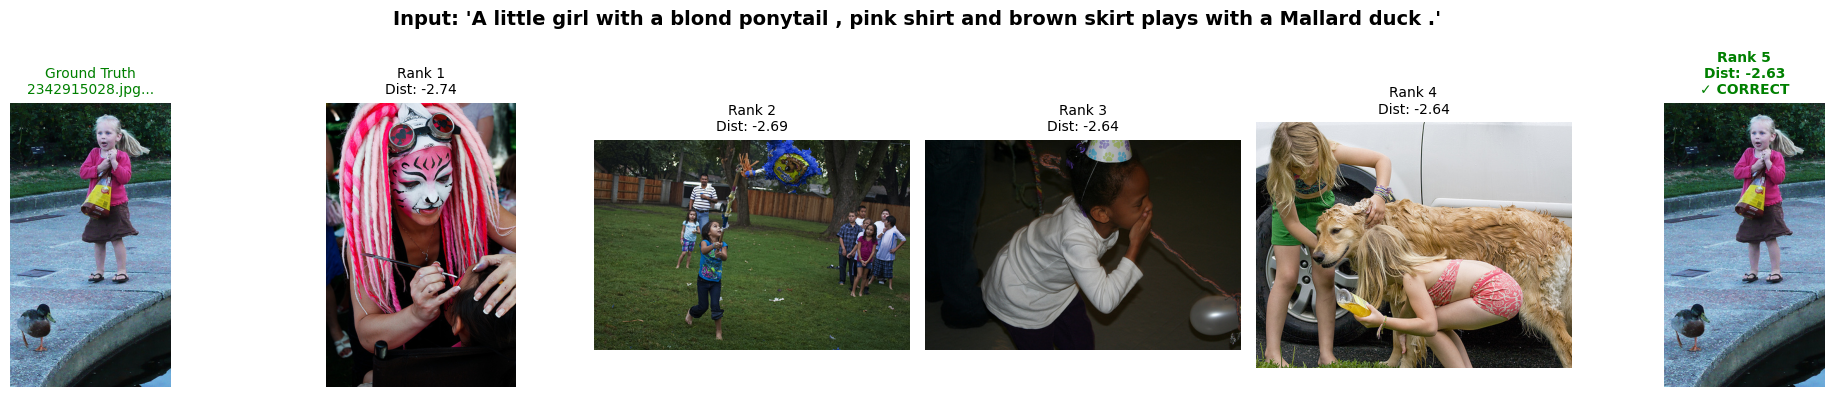

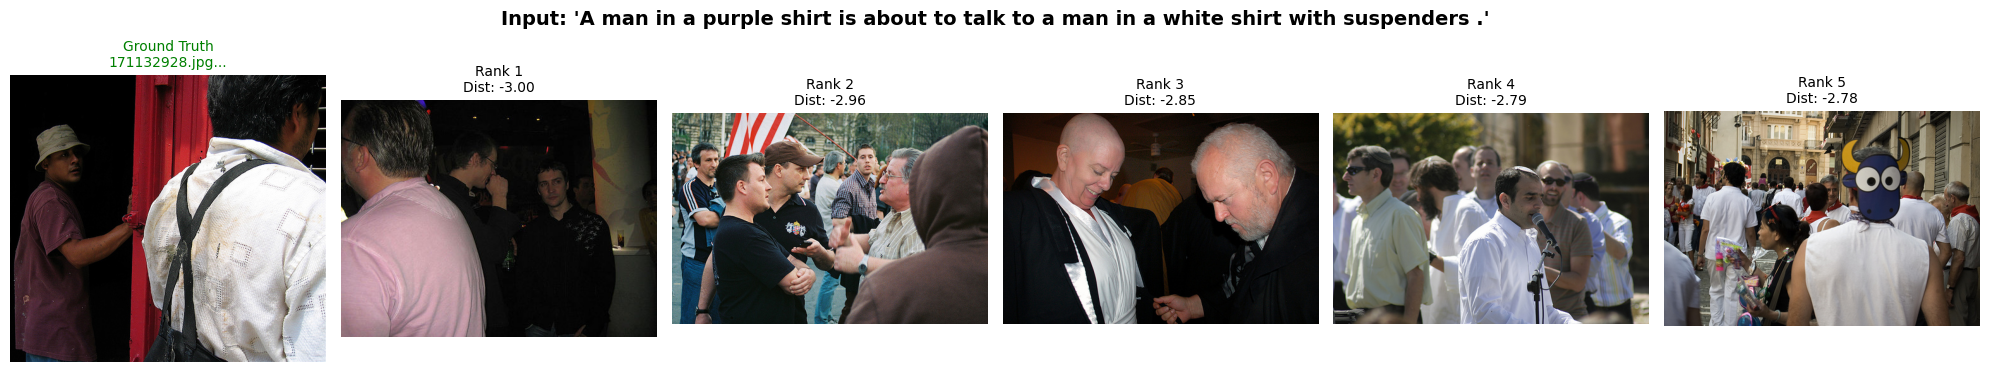

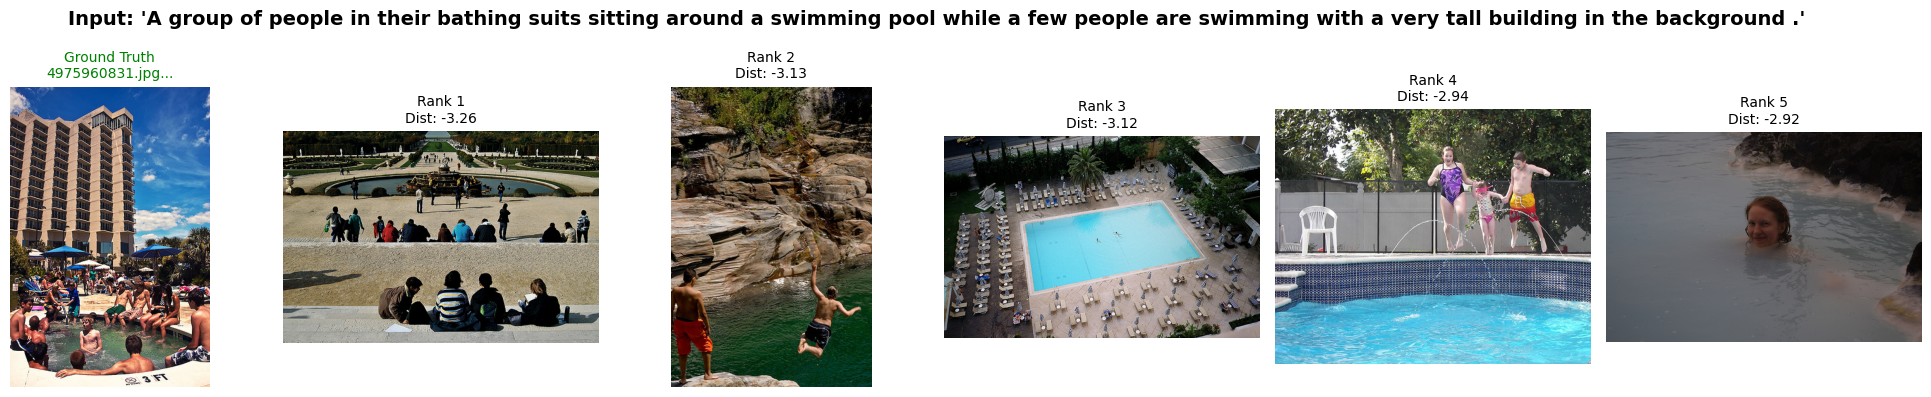

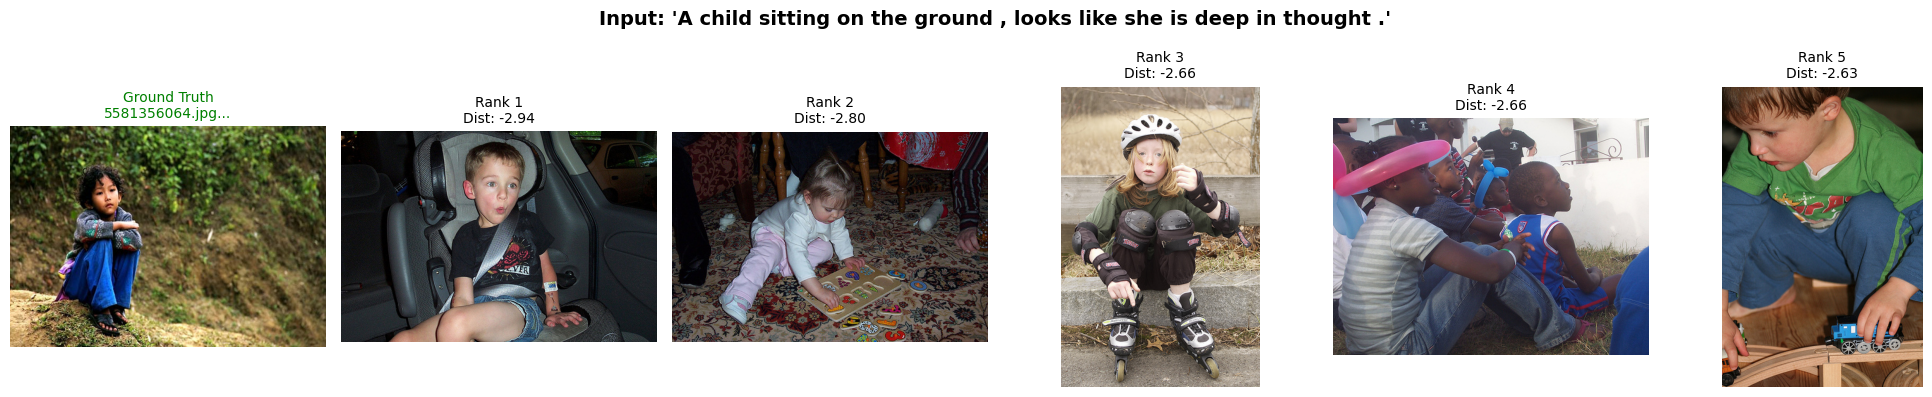

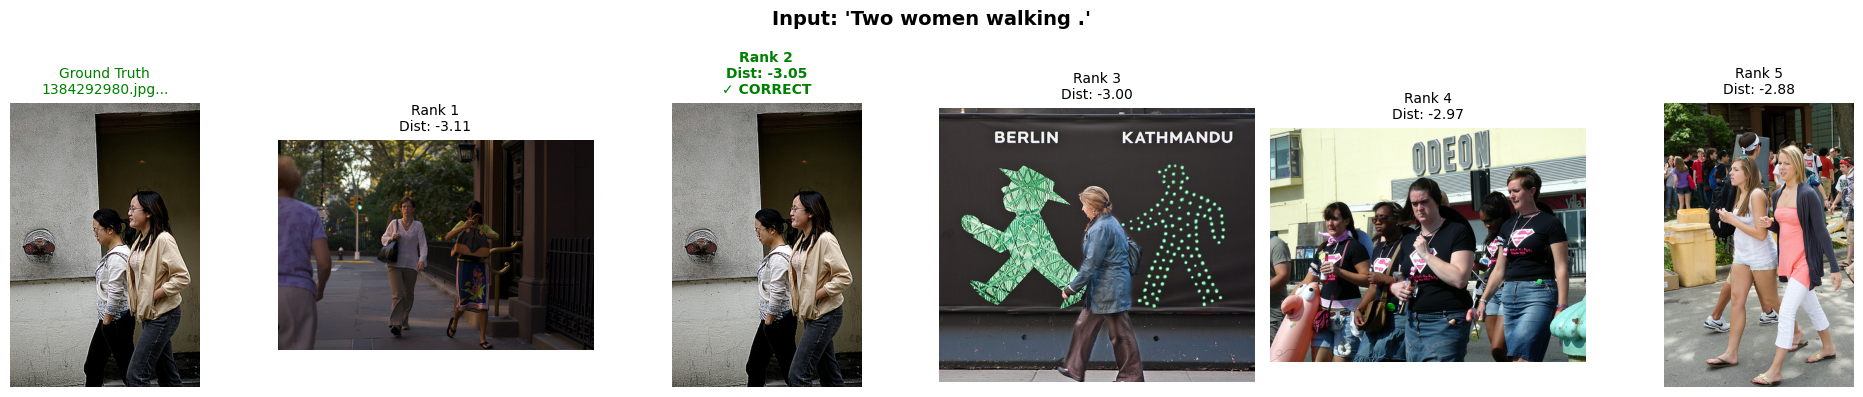

📊 Computing retrieval metrics (Fixed Gallery Size: 128)...
   Text embeddings shape: torch.Size([12500, 1536])
   Image embeddings shape: torch.Size([2500, 1536])
   Fixed gallery size per query: 128 images
   Predicted indices shape: (12500, 128)
   Ground truth indices shape: (12500,)

📊 Validation Metrics (Fixed Gallery Size: 128)
  MRR:       0.8685 (86.85%)
  Recall@1:  0.7941 (79.41%)
  Recall@5:  0.9615 (96.15%)
  Recall@10: 0.9819 (98.19%)
  NDCG@10:   0.8959 (89.59%)
✅ Using fixed gallery size of 128 for dataset-independent metrics
   Each query evaluated against: 1 GT + 127 random negatives
   Total queries evaluated: 12,500



In [17]:
print("Preparing validation data...")
# Extract validation subset
val_caption_text = train_data["captions/text"][~TRAIN_SPLIT]
val_text_embd = X_val

# Get the original label matrix for validation
label_matrix = torch.from_numpy(train_data["captions/label"]).bool()

# Get validation images (only those referenced by validation captions)
img_VAL_SPLIT = label_matrix[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data["images/names"][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data["images/embeddings"][img_VAL_SPLIT])

# Map validation captions to their ground truth images
# For evaluation, we take the first matching image for each caption
val_label = np.nonzero(train_data["captions/label"][~TRAIN_SPLIT][:, img_VAL_SPLIT])[1]
print("✅ Validation data prepared")
print(f"   Validation captions: {len(val_text_embd)}")
print(f"   Validation images: {len(val_img_embd)}")
print(f"   Ground truth mappings: {len(val_label)}")

# Visualize random retrieval examples
visualize_random_samples(
    model=best_model,
    val_text_embd=val_text_embd,
    val_caption_text=val_caption_text,
    val_label=val_label,
    val_img_file=val_img_file,
    val_img_embd=val_img_embd,
    device=DEVICE,
    data_dir=DATA_DIR,
    num_samples=5,
)

# Compute full evaluation metrics
metrics_full = compute_and_print_metrics_full_gallery(
    model=best_model,
    val_text_embd=val_text_embd,
    val_label=val_label,
    val_img_embd=val_img_embd,
    device=DEVICE
)

# Generate Final Submission

Load test data and create the final submission file.

In [18]:
# Load test data
test_data = load_data(DATA_DIR + "/test/test.clean.npz")

# Generate submission file
create_submission_file(
    model=best_model,
    test_data=test_data,
    device=DEVICE,
    output_filename="submission_cm3.csv",
    model_path=MODEL_PATH,
)


🔮 Generating predictions for test set...
   Loaded 1,500 test samples
   Test embedding shape: torch.Size([1500, 1024])
✅ Predictions generated: torch.Size([1500, 1536])
Generating submission file...
✓ Saved submission to submission_cm3.csv

💾 Submission file saved: submission_cm3.csv
   Model used: models/vae/model.pth
   Number of predictions: 1,500

🎉 Ready for Kaggle submission!


id                                          embedding
0        1  [0.01703876070678234, 0.016379648819565773, 0....
1        2  [-0.006161603145301342, 0.0042513334192335606,...
2        3  [0.006113224197179079, -0.004618676844984293, ...
3        4  [0.02177436463534832, -0.006180272903293371, -...
4        5  [0.058621328324079514, 0.043855682015419006, -...
...    ...                                                ...
1495  1496  [-0.006443887948989868, 0.030316483229398727, ...
1496  1497  [-0.010937505401670933, 0.03733644634485245, 0...
1497  1498  [0.014500200748443604, -0.019499287009239197, ...
1498  1499  [0.003218755591660738, -0.00795532576739788, -...
1499  1500  [0.014948674477636814, -0.043841663748025894, ...

[1500 rows x 2 columns]